# COLLISION ÉLASTIQUE DE DEUX DISQUES

In [1]:
import urllib
import os
from notebook import notebookapp

import numpy as np
import math

from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, Slider, Button, TextInput, Legend
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.events import ButtonClick

from bokeh.io import output_notebook, show, export_png

from time import sleep

import imageio

from IPython.display import Image

output_notebook()

Loading BokehJS ...

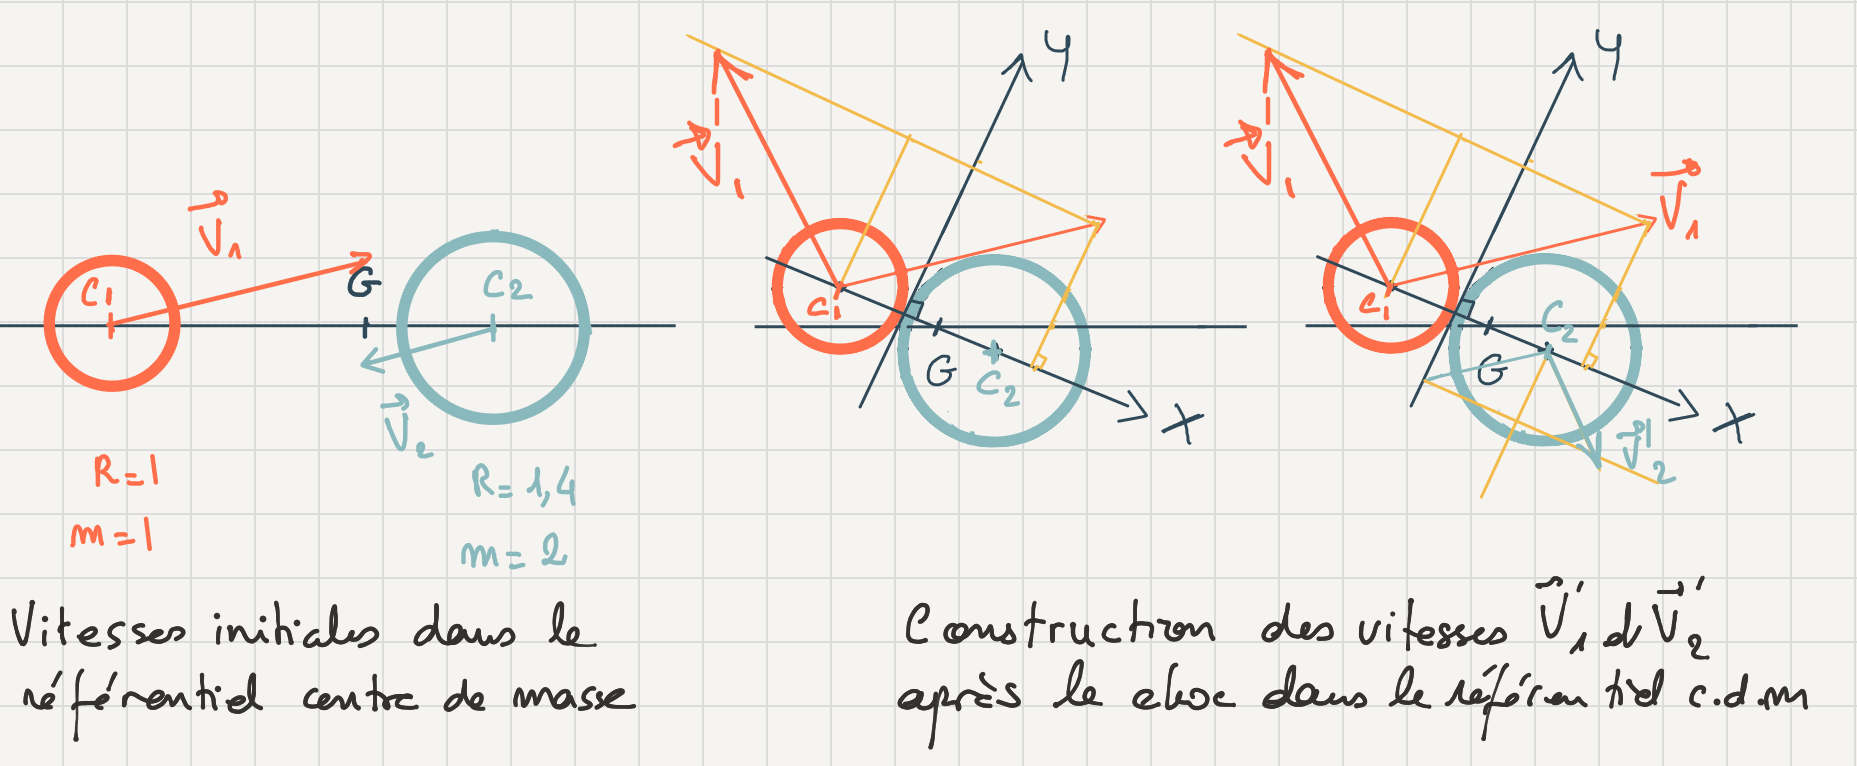

In [2]:
Image("chocs.png")

Deux disques homogènes et de même densité entrent en collision sur une table horizontale où ils se déplacent sans frottements. 

Pour chaque disque, on donne:
* Son rayon (radius)
* Les coordonnées x et y initiales de son centre
* La norma de sa vitesse initiale
* L'angle que fait sa vitesse initiale avec l'horizontal $\alpha$

Pour chaque disque: $m = \rho h (d \pi R^2)$

En considérant que les disques ont la même épaisseur h et masse volumique $\rho$, et en prenant $2 \pi \rho h = 1$ 
$$ m = R^2$$

On prend un temps t divisé en entervalles **dt**. A chaque instantm, la position du centre de disques est donnée par 
$$ \overrightarrow{c_o c} = \int \overrightarrow{v} dt $$

Pour le calcul des vitesses, on travaille dans le référentiel **centre de masse**.

Les disques entrent en collision si:
$$ (R_1 + R_2)^2 \geq (c_1 c_2)^2$$

Si il a y collision, commes les objects sont des disques, ils subissent une collision frontale  par la composante des vitesses colinéaire à $\overrightarrow{c_1 c_2}$ et aucune collision par la composante perpendiculaire à $\overrightarrow{c_1 c_2}$ 

Le choc se calcule dans le référentiel centre de masse. 

Soient $\overrightarrow{v_1}$ et $\overrightarrow{v_2}$ les vitesses avant le choc et $\overrightarrow{v_1^{'}}$ et $\overrightarrow{v_2^{'}}$ après. 

$$ \overrightarrow{v_G} = \frac{m_1 \overrightarrow{v_1} + m_2 \overrightarrow{v_2}}{m_1 + m_2}$$

dans le référence centre de masse, les vitesses sont $\overrightarrow{\nu_1}$, $\overrightarrow{\nu_2}$, $\overrightarrow{\nu_1^{'}}$ et $\overrightarrow{\nu_2^{'}}$

$$ \overrightarrow{\nu_1} = \overrightarrow{v_1} - \overrightarrow{v_G}$$

Si on appele X l'axe ($C_1 C_2)$ et Y l'axe perpendiculaire, après le chox, $\overrightarrow{\nu_1^{'}}$ vitesse de palet 1 s'obtient comme

 $$ \overrightarrow{\nu_1^{'}} = -(\overrightarrow{\nu_1} \cdot \overrightarrow{e_x})\overrightarrow{e_x} + (\overrightarrow{\nu_1} \cdot \overrightarrow{e_y}  )\overrightarrow{e_y}  $$

après le choc,

$$ \overrightarrow{v_1^{'}} = \overrightarrow{\nu_1{'}} +  \overrightarrow{v_G}$$ 

et 

$$ \overrightarrow{v_2^{'}} = \overrightarrow{\nu_2{'}} +  \overrightarrow{v_G}$$ 

## Ensemble de fonctions pour définir divers paramètres



### Fonctions pour référence laboratoire

In [16]:
# fonction pour calculer la masse
mass = lambda P :  3*np.pi*(1e-3)* P['radius']**2 #height = 3cm V=pi*r**2*h

# fonction pour calculer vitesse en x et y 
vel_ = lambda P: (P['v']*np.cos(np.deg2rad(P['alpha'])), P['v']*np.sin(np.deg2rad(P['alpha'])))

# fonction pour calculer la position des disques
new_ = lambda P, dt: (P['x'] + P['vx']*dt, P['y'] + P['vy']*dt)

# fonction pour calculer le centre de gravité du système 
get_CG = lambda P1, P2: (P1['x']*P1['m']/(P1['m']+P2['m']) + P2['x']*P2['m']/(P1['m']+P2['m']), \
                        P1['y']*P1['m']/(P1['m']+P2['m']) + P2['y']*P2['m']/(P1['m']+P2['m']))

# fonction pour calculer la distance entre les deux disques
dist_ = lambda P1, P2: math.sqrt((P1['x'] - P2['x'])**2 + (P1['y'] - P2['y'])**2)

# calculer la projection de la vitesse sur un vecteur 
proj_v = lambda P, vecteur: (P['vx']*vecteur[0] + P['vy']*vecteur[1])/(np.linalg.norm(x))**2


proj_v_vec = lambda P, x: proj_v(P,x)*x

# calcul énergie cinétique
e_cinetique = lambda P: 0.5*P['m']*P['v']**2/1000


# calcul velocité après une collision
def new_vels(P1, P2, u):
    v1 = np.array((P1['vx'], P1['vy']))
    v2 = np.array((P2['vx'], P2['vy']))
    v1_f = v1 - 2*P2['m']/(P1['m']+P2['m'])*np.dot((v1-v2), u)/(np.dot(u,u))*u
    v2_f = v2 - 2*P1['m']/(P1['m']+P2['m'])*np.dot((v2-v1), -u)/(np.dot(u,u))*(-u)

    return v1_f, v2_f
    
def convert_to_array(P):
        for k in ['x', 'init_x', 'y', 'init_y']:
            P[k] = np.array(P[k])

### Fonctions pour référence centre de gravité 

In [17]:
# fonction pour calculer la trajectoire
trajCG_ = lambda P, t, dt:  [P['x'] + P['CGv_x']*np.linspace(0, t, t/dt)/10, P['y'] + P['CGv_y']*np.linspace(0, t, t/dt)/10]

# fonction pour calculer la position des disques
newCG_ = lambda P, dt: (P['x'] + P['CGv_x']*dt, P['y'] + P['CGv_y']*dt)


# calculer la projection de la vitesse sur un vecteur
projCG_v = lambda P, x: (P['CGv_x']*x[0] + P['CGv_y']*x[1])/(np.linalg.norm(x))**2



def new_velsCG(P1, P2, u):
    v1 = np.array((P1['CGv_x'], P1['CGv_y']))
    v2 = np.array((P2['CGv_x'], P2['CGv_y']))
    v1_f = v1 - 2*P2['m']/(P1['m']+P2['m'])*np.dot((v1-v2), u)/(np.dot(u,u))*u
    v2_f = v2 - 2*P1['m']/(P1['m']+P2['m'])*np.dot((v2-v1), -u)/(np.dot(u,u))*(-u)

    return v1_f, v2_f

## Ensemble de fonctions to mettre à jour divers paramètres 

## Référence laboratoire

In [28]:
# Valeurs a t=0
def initialize(t, x_a, x_b, y_a, y_b, v_a, v_b, alpha_a, alpha_b, rad_a, rad_b):
    A = {'x': x_a, 'y': y_a, 'v':v_a, 'alpha': alpha_a, 'radius': rad_a, 't':t, 'name':'A'}
    B = {'x': x_b, 'y': y_b, 'v':v_b, 'alpha': alpha_b, 'radius': rad_b, 't':t, 'name':'B'}

    A['vx'], A['vy'] = vel_(A)
    B['vx'], B['vy'] = vel_(B) 
    
    A['init_vx'], A['init_vy'] = A['vx'], A['vy']
    B['init_vx'], B['init_vy'] = B['vx'], B['vy']

    A['m'], B['m'] = mass(A), mass(B)
    A['E'], B['E'] = [e_cinetique(A)], [e_cinetique(B)]
    A['vitesse'], B['vitesse'] = [A['v']], [B['v']]
    
    CG = {}
    CG['m'] = (A['m'] + B['m'])
    CG['x'] = (1/CG['m']) * (A['x']*A['m'] + B['x']*B['m'])
    CG['y'] = (1/CG['m']) * (A['y']*A['m'] + B['y']*B['m'])
    CG['vx'] = (1/CG['m']) * (A['vx']*A['m'] + B['vx']*B['m'])
    CG['vy'] = (1/CG['m']) * (A['vy']*A['m'] + B['vy']*B['m'])
    return A,B, CG


# Mettre à jour position
def update_position(P1, P2, CG, dt):
    """ calculer la nouvelle position"""
    P1['x'], P1['y'] = new_(P1, dt)
    P2['x'], P2['y'] = new_(P2, dt)
    CG['x'], CG['y'] = get_CG(P1, P2)

    
# Mettre à jour velocité
def update_velocity(P1, P2):
    """ calculer la velocité après collision entre les deux particules"""
    # calculer vecteur collision
    u = np.array([P2['x'] - P1['x'], P2['y'] - P1['y']])

    # point collision
    p_x = P1['x'] + u[0]*P1['radius']/dist_(P1,P2)
    p_y = P1['y'] + u[1]*P1['radius']/dist_(P1,P2)


    # mettre à jour velocité après collision
    p1_v, p2_v = new_vels(P1, P2, u)

    P1['vx'], P1['vy'] = p1_v[0], p1_v[1]
    P2['vx'], P2['vy'] = p2_v[0], p2_v[1]


    P1['v'] = math.sqrt(P1['vx']**2 + P1['vy']**2)
    P2['v'] = math.sqrt(P2['vx']**2 + P2['vy']**2)


def verifier_limites(P, scenario):
    """ calculer velocité après collision entre particules et un des limites du scénario"""

    col = False # boolean pour indiquer si il y a collision ou pas 
    sf = 1.1 #safety factor for plotting 

    # verifier si il y a une collision entre P et limite superiéure
    if P['y'] >= scenario['y_MAX'] - P['radius']*sf: # -5 pour épaisseur de la ligne
        col = True
        u = np.array([0, -1])
        w = np.array([1, 0])


    # verifier si il y a une collision entre P et limite inferiéure
    elif P['y'] <= scenario['y_MIN'] + P['radius']*sf: #+3
        col = True
        u = np.array([0, 1])
        w = np.array([-1, 0])


    # verifier si il y a une collision entre P et limite droite
    elif P['x'] >= scenario['x_MAX'] - P['radius']*sf: #-3
        col = True
        u = np.array([-1, 0])
        w = np.array([0, 1])


    # verifier si il y a une collision entre P et limite gauche
    elif P['x'] <= scenario['x_MIN'] + P['radius']*sf: #+3
        col = True
        u = np.array([1, 0])
        w = np.array([0, -1])

    # si il y a eu une collision, mettre à jour la velocité 
    if col:

        v = np.array((P['vx'], P['vy']))
        v_w = np.dot(v,w)/(np.dot(w,w))*w
        v_u = -(v - v_w)

        P['vx'], P['vy'] = v_u + v_w 

        P['v'] = math.sqrt(P['vx']**2 + P['vy']**2)


def update_values_time(P1, P2, CG, dt, scenario):
    """ calcules évolution des valeurs dans le temps"""
    t = 0
    P1['traj'] = [(P1['x'], P1['y'])]
    P2['traj'] = [(P2['x'], P2['y'])]
    CG['traj'] = [(CG['x'], CG['y'])]

    P1['init_x'] = P1['x']
    P1['init_y'] = P1['y']
    P2['init_x'] = P2['x']
    P2['init_y'] = P2['y']
    CG['init_x'] = CG['x']
    CG['init_y'] = CG['y']

    P1['E'], P2['E'] = [e_cinetique(P1)], [e_cinetique(P2)]
    P1['vitesse'], P2['vitesse'] = [P1['v']], [P2['v']]
    CG['vitesse'] = [(CG['vx'], CG['vy'])]
    
    while t < min(P1['t'], P2['t']):

        # calculer prochain possition
        update_position(P1, P2, CG, dt)
        P1['E'].append(e_cinetique(P1))
        P2['E'].append(e_cinetique(P2))
        P1['vitesse'].append(P1['v'])
        P2['vitesse'].append(P2['v'])

        P1['traj'].append((P1['x'], P1['y']))
        P2['traj'].append((P2['x'], P2['y']))
        CG['traj'].append((CG['x'], CG['y']))

        # verifier si il y a une collision entre P1 et P2
        if dist_(P1, P2) < (P1['radius']*1.075 + P2['radius']*1.075):            
            update_velocity(P1, P2)
            

        # verifier si il y a collision avec les limites du scenario
        verifier_limites(P1, scenario)
        verifier_limites(P2, scenario)
        
        CG_vx = (1/CG['m']) * (P1['vx']*P1['m'] + P2['vx']*P2['m'])
        CG_vy = (1/CG['m']) * (P1['vy']*P1['m'] + P2['vy']*P2['m'])
        CG['vitesse'].append((CG_vx, CG_vy))


        t += dt  

    P1['traj'] = np.array(P1['traj'])
    P2['traj'] = np.array(P2['traj'])
    CG['traj'] = np.array(CG['traj'])
    P1['E'] = np.array(P1['E'])
    P2['E'] = np.array(P2['E'])
    P1['vitesse'] = np.array(P1['vitesse'])
    P2['vitesse'] = np.array(P2['vitesse'])

In [30]:
def generate_figure(scenario, source_A, source_B, source_A_trj, source_B_trj, source_CG, A, B, CG, alpha):
    line_width_grille = 0.5
    alpha_grille = 0.3
    
    
    # Figure référence laboratoire
    p = figure(title="Collision", plot_height=448, plot_width=896, y_range=(scenario['y_MIN'], scenario['y_MAX']), 
               x_range=(scenario['x_MIN'], scenario['x_MAX']), 
               background_fill_color='#ffffff')
    p.toolbar.logo = None
    p.toolbar_location = None
    
    
    # Grille en movement pour video reference CG
    x_gridlineh = np.linspace(scenario['x_MIN'], scenario['x_MAX'], 31)
    y_gridlinev = np.linspace(scenario['y_MIN'], scenario['y_MAX'], 16)
    
    x_GRID = [scenario['x_MIN'], scenario['x_MAX']]
    y_GRID = [scenario['y_MIN'], scenario['y_MAX']]
    
    line_width_grille = 0.5
    alpha_grille = 0.3
    
    g_horizontale = []
    for idx, y_val in enumerate(y_gridlinev):
        if idx == 0 or idx == 15:
            g_horizontale.append(p.line(x=x_GRID, y=[y_val]*2, line_color='#000000', \
                                  alpha=1, line_width=line_width_grille*3))
        else: 
            g_horizontale.append(p.line(x=x_GRID, y=[y_val]*2, line_color='#000000', \
                                  alpha=alpha_grille, line_width=line_width_grille))
   
    g_verticale = []
    for idx, x_val in enumerate(x_gridlineh):
        if idx == 0 or idx == 30:
            g_verticale.append(p.line(x=[x_val]*2, y=y_GRID, line_color='#000000', \
                                  alpha=1, line_width=line_width_grille*3))
            
        
        else:
            g_verticale.append(p.line(x=[x_val]*2, y=y_GRID, line_color='#000000', \
                                  alpha=alpha_grille, line_width=line_width_grille))
        
    
    # limites du scénario
    p.line(x=np.linspace(scenario['x_MIN'],scenario['x_MAX'], 3), y=[scenario['y_MIN']]*3, line_color='#000000', line_width=2)
    p.line(x=np.linspace(scenario['x_MIN'],scenario['x_MAX'], 3), y=[scenario['y_MAX']]*3, line_color='#000000', line_width=2)
    p.line(x=[scenario['x_MIN']]*3, y=np.linspace(scenario['y_MIN'],scenario['y_MAX'], 3), line_color='#000000', line_width=2)
    p.line(x=[scenario['x_MAX']]*3, y=np.linspace(scenario['y_MIN'],scenario['y_MAX'], 3), line_color='#000000', line_width=2)
    
    # Disques
    P_A = p.circle(x='x', y='y', radius='radius', source = source_A, fill_color='#e32020', line_color='#e32020', alpha=0.8)
    P_B = p.circle(x='x', y='y', radius='radius', source = source_B, fill_color='#0ABDE3', line_color='#0ABDE3', alpha=0.8)

    # Trajectoire
    Traj_A = p.line(x='x_t', y='y_t', source=source_A_trj, color='#e32020', line_dash='dashed')
    Traj_B = p.line(x='x_t', y='y_t', source=source_B_trj, color='#0ABDE3', line_dash='dashed')
    
    
    # Centre de gravité du système de masses 
    p_CG = p.circle(x='x', y='y', source=source_CG, size=3, fill_color='#000000', line_color='#000000')
    
    # Vecteur vitesse centre de gravité
    l_vel_CG = p.line(x=np.linspace(CG['init_x'], CG['init_x'] + CG['vx']*5, 2), \
                y=np.linspace(CG['init_y'], CG['init_y'] + CG['vy']*5, 2), \
                line_width=1, line_color='#000000')
    
    # Vecteur vitesse A et B
    l_vel_A = p.line(x=np.linspace(A['init_x'], A['init_x'] + A['init_vx']*5, 2), \
                    y=np.linspace(A['init_y'], A['init_y'] + A['init_vy']*5, 2), \
                    line_width=1, line_color='#000000')
    
    A_arrow = p.triangle(x=[A['init_x'] + A['init_vx']*5], y =[A['init_y'] + A['init_vy']*5], \
                          angle=alpha, color='#000000', size=5)
    
    l_vel_B = p.line(x=np.linspace(B['init_x'], B['init_x'] + B['init_vx']*5, 2), \
                    y=np.linspace(B['init_y'], B['init_y'] + B['init_vy']*5, 2), \
                    line_width=1, line_color='#000000')
    
    B_arrow = p.triangle(x=[B['init_x'] + B['init_vx']*5], y =[B['init_y'] + B['init_vy']*5], \
                          angle=alpha, color='#000000', size=5)
    
    
    CG_arrow = p.triangle(x=[CG['init_x'] + CG['vx']*5], y =[CG['init_y'] + CG['vy']*5], \
                          angle=alpha, color='#000000', size=5)

    
    legend = Legend(items=[
    ("A"   , [P_A]),
    ("B" , [P_B]),
    ("trajectoire A" , [Traj_A]),
    ("trajectoire B" , [Traj_B]),
    ('CG', [p_CG]),
    ('vitesse', [l_vel_CG]),
    ], location="center")

    p.add_layout(legend, 'above')
    p.legend.orientation = "horizontal"
    p.ygrid.visible = False
    p.xgrid.visible = False
    
    return p, g_horizontale, g_verticale, P_A, P_B, Traj_A, Traj_B, p_CG, l_vel_CG, CG_arrow, l_vel_A, A_arrow, l_vel_B, B_arrow

In [20]:
def create_source(A,B,CG):
    source_A = ColumnDataSource(data = {'x':[A['init_x']], 'y':[A['init_y']], 'radius':[A['radius']]})
    source_B = ColumnDataSource(data = {'x':[B['init_x']], 'y':[B['init_y']], 'radius':[B['radius']]})
    
    source_A_trj = ColumnDataSource(data= {'x_t': A['traj'][:,0], 'y_t': A['traj'][:,1]})
    source_B_trj = ColumnDataSource(data= {'x_t': B['traj'][:,0], 'y_t': B['traj'][:,1]})
    
    source_CG = ColumnDataSource(data = {'x': [CG['init_x']], 'y': [CG['init_y']]})
    
    # Vecteur vitesse CG
    if CG['init_x'] + CG['vx']*5 != 0:
        alpha = np.rad2deg(np.arctan((CG['init_y'] + CG['vy']*5)/(CG['init_x'] + CG['vx']*5)))
    else: 
        alpha = np.rad2deg(np.arctan(10**9))
    
    
    
    return source_A, source_B, source_A_trj, source_B_trj, source_CG, alpha

# LET'S PLAY! 

In [31]:
## PLOT

def modify_doc(doc):
    
    # Conditions initiales 
    dt = 0.005
    T = 10
    x_a, x_b = -25, 25
    
    y_a, y_b = 0,0

    v_a, v_b = 1.5, 1.5 #[cm/s]
    
    alpha_a, alpha_b = 0, 180
    rad_a, rad_b = 2.5, 2.5
    
    # définir limits du scenario (cm)
    Y_MAX = 50
    Y_MIN = -50
    X_MAX = 100
    X_MIN = -100
    
    scenario = {'y_MAX': Y_MAX, 'y_MIN': Y_MIN, 'x_MAX': X_MAX, 'x_MIN': X_MIN}        
    
    # Calculer les valeurs initiales - référence lab
    A, B, CG = initialize(T, x_a, x_b, y_a, y_b, v_a, v_b, alpha_a, alpha_b, rad_a, rad_b) 
    update_values_time(A, B, CG, dt, scenario)
    print(A.keys())
    
    source_A, source_B, source_A_trj, source_B_trj, source_CG, alpha = create_source(A,B,CG)
    source_A_cg, source_B_cg, source_A_trj_cg, source_B_trj_cg, source_CG_cg, alpha_cg = create_source(A,B,CG)
    
    
    
    source_VG = ColumnDataSource(data = {'x': np.linspace(CG['init_x'], CG['init_x'] + CG['vx']*5, 10), \
                                         'y': np.linspace(CG['init_y'], CG['init_y'] + CG['vy']*5, 10)})
    
    source_E = ColumnDataSource(data={'A': np.linspace(0,A['E'][0],10), 'B': np.linspace(A['E'][0], A['E'][0]+B['E'][0],10),
                                      'vA': np.linspace(0, A['vitesse'][0], 10), 'vB': np.linspace(0, B['vitesse'][0], 10), 
                                      'y': [0]*10, 'yA':[4]*10, 'yB':[8]*10})
    
    
    # Figure Énergie 
    p_graphs = figure(plot_height=100, plot_width=896, y_range=[-3,3], title='Énergie cinétique [kJ]')
    p_graphs.toolbar.logo = None
    p_graphs.toolbar_location = None
    
    p_graphs.yaxis.ticker = [0]
    p_graphs.yaxis.major_label_overrides = {0: 'Énergie'}
    
    EC_A = p_graphs.line(y='y', x='A', line_width=5, source=source_E, line_color='#e32020')
    EC_B = p_graphs.line(y='y', x='B', line_width=5, source=source_E, line_color='#0ABDE3')
    
    line_width_grille = 0.5
    alpha_grille = 0.3
    
    p_ref_abs, g_horizontale, g_verticale, P_A, P_B, Traj_A, Traj_B, p_CG, \
    l_vel_CG, CG_arrow, l_vel_A, A_arrow, l_vel_B, B_arrow =\
    generate_figure(scenario, source_A, source_B, source_A_trj, source_B_trj, source_CG, A, B, CG, alpha)
    
    p_ref_cg, g_horizontale_cg, g_verticale_cg, P_A_cg, P_B_cg, Traj_A_cg, Traj_B_cg, \
    p_CG_cg, l_vel_CG_cg, CG_arrow_cg, l_vel_A_cg, A_arrow_cg, l_vel_B_cg, B_arrow_cg =\
    generate_figure(scenario, source_A_cg, source_B_cg, source_A_trj_cg, source_B_trj_cg, source_CG_cg, A, B, CG, alpha_cg)
    
    
    
    # Définir sliders 
    slider_Ax = Slider(start=-95, end=95, value=-25, step=1, title='Ax [cm]:')
    slider_Bx = Slider(start=-95, end=95, value=25, step=1, title='Bx [cm]:')
    
    slider_Ay = Slider(start=-45, end=45, value=0, step=1, title='Ay [cm]:')
    slider_By = Slider(start=-45, end=45, value=0, step=1, title='By [cm]:')
    
    slider_Ar = Slider(start=1, end=5, value=2.5, step=0.1, title='Rayon A [cm]:')
    slider_Br = Slider(start=1, end=5, value=2.5, step=0.1, title='Rayon B [cm]:')
    
    slider_Av = Slider(start=-40, end=40, value=15, step=1, title='Vitesse A [cm/s]:')
    slider_Bv = Slider(start=-40, end=40, value=15, step=1, title='Vitesse [cm/s]:')
    
    slider_A_alpha = Slider(start=0, end=360, value=0, step=5, title='α [º]:')
    slider_B_alpha = Slider(start=0, end=360, value=180, step=5, title='α [º]:')
    
    play = Button(label='play')
    reset = Button(label='reset')
    export = Button(label='export video')
    file_name = TextInput(title='File name', value='collision')
    
    def read_sliders():
        
        x_a = slider_Ax.value
        x_b = slider_Bx.value

        y_a = slider_Ay.value
        y_b = slider_By.value

        v_a = slider_Av.value
        v_b = slider_Bv.value

        alpha_a = slider_A_alpha.value
        alpha_b = slider_B_alpha.value

        rad_a = slider_Ar.value
        rad_b = slider_Br.value

        A, B, CG = initialize(T, x_a, x_b, y_a, y_b, v_a, v_b, alpha_a, alpha_b, rad_a, rad_b) 
        update_values_time(A, B, CG, dt, scenario)
        
        return A, B, CG
    
    
    def refresh_source(attrname, old, new):
        
        l_vel_CG.visible = True
        CG_arrow.visible= True
        
        l_vel_CG_cg.visible = False
        CG_arrow_cg.visible= False
        
        Traj_A_cg.visible = False
        Traj_B_cg.visible = False

        A, B, CG = read_sliders()
        
        source_A.data = {'x':[A['init_x']], 'y':[A['init_y']], 'radius':[A['radius']]}
        source_B.data = {'x':[B['init_x']], 'y':[B['init_y']], 'radius':[B['radius']]}
        source_A_cg.data = {'x':[A['init_x']], 'y':[A['init_y']], 'radius':[A['radius']]}
        source_B_cg.data = {'x':[B['init_x']], 'y':[B['init_y']], 'radius':[B['radius']]}

        source_A_trj.data = {'x_t': A['traj'][:,0], 'y_t': A['traj'][:,1]}
        source_B_trj.data = {'x_t': B['traj'][:,0], 'y_t': B['traj'][:,1]}
        source_A_trj_cg.data = {'x_t': A['traj'][:,0] - CG['traj'][:,0], 'y_t': A['traj'][:,1] - CG['traj'][:,1]}
        source_B_trj_cg.data = {'x_t': B['traj'][:,0] - CG['traj'][:,0], 'y_t': B['traj'][:,1] - CG['traj'][:,1]}
        
        source_CG.data = {'x': [CG['init_x']], 'y': [CG['init_y']]}
        
        source_E.data = {'A': np.linspace(0, A['E'][0], 10), 
                         'B': np.linspace(A['E'][0], A['E'][0] + B['E'][0], 10), 'y':[0]*10}
        
        if CG['init_x'] + CG['vx']*5 != 0:
            alpha = np.rad2deg(np.arctan((CG['init_y'] + CG['vy']*5)/(CG['init_x'] + CG['vx']*5)))
        else: 
            alpha = np.rad2deg(np.arctan(10**9))
            
        mult = 2
        
        l_vel_CG.data_source.data['x'] = np.linspace(CG['init_x'], CG['init_x'] + CG['vx']*mult, 2)
        l_vel_CG.data_source.data['y'] = np.linspace(CG['init_y'], CG['init_y'] + CG['vy']*mult, 2)
        
        CG_arrow.data_source.data['x'] = [CG['init_x'] + CG['vx']*mult] 
        CG_arrow.data_source.data['y'] = [CG['init_y'] + CG['vy']*mult]
        CG_arrow.data_source.data['angle'] = [-alpha]
        
        # vecteur velocité absolute 
        for l, arrow, S in zip([l_vel_A, l_vel_B], [A_arrow, B_arrow], [A, B]):
            l.data_source.data['x'] = np.linspace(S['init_x'], S['init_x'] + S['init_vx']*mult, 2)
            l.data_source.data['y'] = np.linspace(S['init_y'], S['init_y'] + S['init_vy']*mult, 2)
        
            arrow.data_source.data['x'] = [S['init_x'] + S['init_vx']*mult] 
            arrow.data_source.data['y'] = [S['init_y'] + S['init_vy']*mult]
            arrow.data_source.data['angle'] = [-alpha]
        
        # vecteur velocité relative au CG
        for l, arrow, S in zip([l_vel_A_cg, l_vel_B_cg], [A_arrow_cg, B_arrow_cg], [A, B]):
            l.data_source.data['x'] = np.linspace(S['init_x'], S['init_x'] + (S['init_vx'] - CG['vx'])*mult,2)
            l.data_source.data['y'] = np.linspace(S['init_y'], S['init_y'] + (S['init_vy'] - CG['vy'])*mult,2)
            
            arrow.data_source.data['x'] = [S['init_x'] + (S['init_vx'] - CG['vx'])*mult] 
            arrow.data_source.data['y'] = [S['init_y'] + (S['init_vy'] - CG['vy'])*mult] 
            arrow.data_source.data['angle'] = [-alpha_cg] 
        
        
        
        
        
    slider_Ax.on_change('value', refresh_source)
    slider_Bx.on_change('value', refresh_source)
    slider_Ay.on_change('value', refresh_source)
    slider_By.on_change('value', refresh_source)
    slider_Av.on_change('value', refresh_source)
    slider_Bv.on_change('value', refresh_source)
    slider_A_alpha.on_change('value', refresh_source)
    slider_B_alpha.on_change('value', refresh_source)
    slider_Ar.on_change('value', refresh_source)
    slider_Br.on_change('value', refresh_source)
    
    
        
    
    def reset_animation(event):
        Traj_A.visible = True
        Traj_B.visible = True
        
        p_CG.visible = True
        
        l_vel_CG.visible = True
        CG_arrow.visible=True
        
        A, B, CG = read_sliders()
        
        idx = 0
        
        # Grille en movement pour video reference CG
        x_gridlineh = np.linspace(scenario['x_MIN'], scenario['x_MAX'], 31)
        y_gridlinev = np.linspace(scenario['y_MIN'], scenario['y_MAX'], 16)
        
        for g, y_val in zip(g_horizontale_cg, y_gridlinev):
            g.data_source.data['y'] = [y_val]*2
                
        for g, x_val in zip(g_verticale_cg, x_gridlineh):
            g.data_source.data['x'] = [x_val]*2
        
        
        source_A.data = {'x':[A['traj'][idx,0]], 'y':[A['traj'][idx,1]], 'radius':[A['radius']]}
        source_A_cg.data = {'x':[A['traj'][idx,0]], 'y':[A['traj'][idx,1]], 'radius':[A['radius']]}
        source_B.data = {'x':[B['traj'][idx,0]], 'y':[B['traj'][idx,1]], 'radius':[B['radius']]}
        source_B_cg.data = {'x':[B['traj'][idx,0]], 'y':[B['traj'][idx,1]], 'radius':[B['radius']]}
        source_CG.data = {'x': [CG['traj'][idx, 0]], 'y': [CG['traj'][idx, 1]]}
        source_E.data = {'A': np.linspace(0, A['E'][idx], 10), 
                         'B': np.linspace(A['E'][idx], A['E'][idx] + B['E'][idx], 10), 'y':[0]*10}
        
    
    def play_animation(event):
        Traj_A.visible = True
        Traj_B.visible = True
        
        p_CG.visible = True
        
        for l in [l_vel_CG, l_vel_A, l_vel_B, l_vel_CG_cg, l_vel_A_cg, l_vel_B_cg]:
            l.visible = False
        for arrow in [A_arrow, B_arrow, CG_arrow, A_arrow_cg, B_arrow_cg, CG_arrow_cg]:
            arrow.visible=False

        
        A, B, CG = read_sliders()

        t = 0
        idx = 0
        images = []
        sleep(0.1)
        
        while t < A['t']:
            # mettre à jour tous les paramètres pour chaque dt
            source_A.data = {'x':[A['traj'][idx,0]], 'y':[A['traj'][idx,1]], 'radius':[A['radius']]}
            source_B.data = {'x':[B['traj'][idx,0]], 'y':[B['traj'][idx,1]], 'radius':[B['radius']]}
            source_CG.data = {'x': [CG['traj'][idx, 0]], 'y': [CG['traj'][idx, 1]]}
            source_E.data = {'A': np.linspace(0, A['E'][idx], 10), 
                         'B': np.linspace(A['E'][idx], A['E'][idx] + B['E'][idx], 10), 'y':[0]*10}
            
            t += dt
            idx += 1
        
        t = 0
        idx = 0
        images = []
        sleep(0.1)
        
        Traj_A_cg.visible = False
        Traj_B_cg.visible = False
        
        speed = 15
        
        while t < A['t']:
            # mettre à jour tous les paramètres pour chaque dt
            source_A_cg.data = {'x':[A['traj'][idx,0] - CG['traj'][idx, 0]], 'y':[A['traj'][idx,1] - CG['traj'][idx, 1]], 'radius':[A['radius']]}
            source_B_cg.data = {'x':[B['traj'][idx,0] - CG['traj'][idx, 0]], 'y':[B['traj'][idx,1] - CG['traj'][idx, 1]], 'radius':[B['radius']]}
            source_CG_cg.data = {'x': [CG['traj'][idx, 0] - CG['traj'][idx, 0]], 'y': [CG['traj'][idx, 1] - CG['traj'][idx, 1]]}
            
            for g in g_horizontale_cg:
                g.data_source.data['y'] += -CG['vitesse'][idx][1]*dt*speed
                    
            for g in g_verticale_cg:
                g.data_source.data['x'] += -CG['vitesse'][idx][0]*dt*speed
            
            
            t += dt*speed
            idx += speed
        

    play.on_event(ButtonClick, play_animation)
    reset.on_event(ButtonClick, reset_animation)
    

    layout = column(row(slider_Ax, slider_Bx),\
        row(slider_Ay, slider_By),\
        row(slider_Ar, slider_Br),\
        row(slider_Av, slider_Bv),\
        row(slider_A_alpha, slider_B_alpha), \
        row(play, reset), row(p_ref_abs), row(p_graphs),row(p_ref_cg))

    
    doc.add_root(layout)



def remote_jupyter_proxy_url(port):
    """
    Callable to configure Bokeh's show method when a proxy must be
    configured.

    If port is None we're asking about the URL
    for the origin header.
    """
    
    base_url = os.environ['EXTERNAL_URL']
    host = urllib.parse.urlparse(base_url).netloc

    # If port is None we're asking for the URL origin
    # so return the public hostname.
    if port is None:
        return host

    service_url_path = os.environ['JUPYTERHUB_SERVICE_PREFIX']
    proxy_url_path = 'proxy/%d' % port

    user_url = urllib.parse.urljoin(base_url, service_url_path)
    full_url = urllib.parse.urljoin(user_url, proxy_url_path)
    return full_url



def show_document(doc):
    servers = list(notebookapp.list_running_servers())[0]
    if servers['hostname'] == 'localhost':
        show(doc) 
    else:
        show(doc, notebook_url=remote_jupyter_proxy_url)


        
        
show_document(modify_doc)    

dict_keys(['x', 'y', 'v', 'alpha', 'radius', 't', 'name', 'vx', 'vy', 'init_vx', 'init_vy', 'm', 'E', 'vitesse', 'traj', 'init_x', 'init_y'])


In [22]:
"""
adapted figures- now working animation one after the other. 

VAUES ARE NOT CORRECT! 

- TODO: 
* CHECK GENERATION OF TRAJECTORIES IN REF CG
* REFRESH DRAWING IN REF CG WHEN MOVING SLIDERS
* CLEAN UP CODE - MORE THINGS CAN BE INTEGRATED AS FUNCTIONS? 

"""

'\nadapted figures- now working animation one after the other. \n\nVAUES ARE NOT CORRECT! \n\n- TODO: \n* CHECK GENERATION OF TRAJECTORIES IN REF CG\n* REFRESH DRAWING IN REF CG WHEN MOVING SLIDERS\n* CLEAN UP CODE - MORE THINGS CAN BE INTEGRATED AS FUNCTIONS? \n\n'

## REFENCE: CENTRE DE GRAVITÉ

In [23]:
"""HOW IT IS WORKING NOW: 

- CG IS FIXED FOR THE ANIMATION BUT NOT ITS INITIAL POSITION 
(CAN BE CHANGED TO GET THE VALUES OF THE SLIDER WRT THE CG AND FIX THE CG TO BE ALWAYS AT 0,0 )

- THE TWO PARTICLES MOVE WITH A SPEED IN THE REFERENCE OF THE CG

- THERE ARE NO LIMITS ON THE SCENARIO 

TODO: 

- PRINT VALUES OF SPEED IN THE TWO REFERENCE FRAMEWORKS? 
- EXAMPLE: http://www.sc.ehu.es/sbweb/fisica3/dinamica/choques/choques_2.html

"""

'HOW IT IS WORKING NOW: \n\n- CG IS FIXED FOR THE ANIMATION BUT NOT ITS INITIAL POSITION \n(CAN BE CHANGED TO GET THE VALUES OF THE SLIDER WRT THE CG AND FIX THE CG TO BE ALWAYS AT 0,0 )\n\n- THE TWO PARTICLES MOVE WITH A SPEED IN THE REFERENCE OF THE CG\n\n- THERE ARE NO LIMITS ON THE SCENARIO \n\nTODO: \n\n- PRINT VALUES OF SPEED IN THE TWO REFERENCE FRAMEWORKS? \n- EXAMPLE: http://www.sc.ehu.es/sbweb/fisica3/dinamica/choques/choques_2.html\n\n'

In [11]:
"""
    
    g_horizontale = []
    for y_val in y_gridlinev:
        g_horizontale.append(p_ref_abs.line(x=x_gridlineh, y=[y_val]*31, line_color='#000000', \
                                  alpha=alpha_grille, line_width=line_width_grille))
   
    g_verticale = []
    for x_val in x_gridlineh:
        g_verticale.append(p_ref_abs.line(x=[x_val]*16, y=y_gridlinev, line_color='#000000', \
                                  alpha=alpha_grille, line_width=line_width_grille))
        
    
    # limites du scénario
    p_ref_abs.line(x=np.linspace(scenario['x_MIN'],scenario['x_MAX'], 3), y=[scenario['y_MIN']]*3, line_color='#000000', line_width=2)
    p_ref_abs.line(x=np.linspace(scenario['x_MIN'],scenario['x_MAX'], 3), y=[scenario['y_MAX']]*3, line_color='#000000', line_width=2)
    p_ref_abs.line(x=[scenario['x_MIN']]*3, y=np.linspace(scenario['y_MIN'],scenario['y_MAX'], 3), line_color='#000000', line_width=2)
    p_ref_abs.line(x=[scenario['x_MAX']]*3, y=np.linspace(scenario['y_MIN'],scenario['y_MAX'], 3), line_color='#000000', line_width=2)
    
    # Disques
    P_A = p_ref_abs.circle(x='x', y='y', radius='radius', source = source_A, fill_color='#e32020', line_color='#e32020', alpha=0.8)
    P_B = p_ref_abs.circle(x='x', y='y', radius='radius', source = source_B, fill_color='#0ABDE3', line_color='#0ABDE3', alpha=0.8)

    # Trajectoire
    Traj_A = p_ref_abs.line(x='x_t', y='y_t', source=source_A_trj, color='#e32020', line_dash='dashed')
    Traj_B = p_ref_abs.line(x='x_t', y='y_t', source=source_B_trj, color='#0ABDE3', line_dash='dashed')
    
    
    # Centre de gravité du système de masses 
    p_CG = p_ref_abs.circle(x='x', y='y', source=source_CG, size=3, fill_color='#000000', line_color='#000000')
    
    # Vecteur vitesse centre de gravité
    l_vel_CG = p_ref_abs.line(x=np.linspace(CG['init_x'], CG['init_x'] + CG['vx']*5, 10), \
                y=np.linspace(CG['init_y'], CG['init_y'] + CG['vy']*5, 10), \
                line_width=1, line_color='#000000')
    
    CG_arrow = p_ref_abs.triangle(x=[CG['init_x'] + CG['vx']*5], y =[CG['init_y'] + CG['vy']*5], \
                          angle=alpha, color='#000000', size=5)

    
    legend = Legend(items=[
    ("A"   , [P_A]),
    ("B" , [P_B]),
    ("trajectoire A" , [Traj_A]),
    ("trajectoire B" , [Traj_B]),
    ('CG', [p_CG]),
    ('vitesse CG', [l_vel_CG]),
    ], location="center")

    p_ref_abs.add_layout(legend, 'above')
    p_ref_abs.legend.orientation = "horizontal"
    p_ref_abs.ygrid.visible = False
    p_ref_abs.xgrid.visible = False
    """

'\n    \n    g_horizontale = []\n    for y_val in y_gridlinev:\n        g_horizontale.append(p_ref_abs.line(x=x_gridlineh, y=[y_val]*31, line_color=\'#000000\',                                   alpha=alpha_grille, line_width=line_width_grille))\n   \n    g_verticale = []\n    for x_val in x_gridlineh:\n        g_verticale.append(p_ref_abs.line(x=[x_val]*16, y=y_gridlinev, line_color=\'#000000\',                                   alpha=alpha_grille, line_width=line_width_grille))\n        \n    \n    # limites du scénario\n    p_ref_abs.line(x=np.linspace(scenario[\'x_MIN\'],scenario[\'x_MAX\'], 3), y=[scenario[\'y_MIN\']]*3, line_color=\'#000000\', line_width=2)\n    p_ref_abs.line(x=np.linspace(scenario[\'x_MIN\'],scenario[\'x_MAX\'], 3), y=[scenario[\'y_MAX\']]*3, line_color=\'#000000\', line_width=2)\n    p_ref_abs.line(x=[scenario[\'x_MIN\']]*3, y=np.linspace(scenario[\'y_MIN\'],scenario[\'y_MAX\'], 3), line_color=\'#000000\', line_width=2)\n    p_ref_abs.line(x=[scenario[\'x_MAX\

-- add vector of velocity for each ball
-- initial position in ref center of mass
-- check the grid
-- add sliders to adjust time of simulation